# Binder Cumulants
From *"Thermal BCS-BEC Crossovers in finite systems"*:

*1.8 Binder cumulants*

Remind that in probability theory, a cumulant is a statistical measure that describes characteristics of a probability distribution, similar to moments. 
They are particularly useful because they simplify when random variables are added, as the cumulants of the sum of independent variables are simply the sums of the individual cumulants. 
The first few cumulants correspond to the mean, variance, skewness, and kurtosis of a distribution. The Binder cumulant (often denoted U4) is a dimensionless quantity introduced by Kurt Binder to study phase transitions and finite-size scaling in statistical physics. 
It is essentially a normalized fourth-order cumulant of an order parameter (e.g. magnetization, density of pairs, etc.) [32]. 
For an order parameter $\theta$, the Binder cumulant is defined as: 
$$
U_4 = 1 - \frac{\left<{\theta^4}\right>}{3\left<{\theta^2}\right>^2}
$$
*1.8.1 Why is it useful?*
Let us answer with a list. 
  1. Detecting phase transitions: Near a critical point, the probability distribution of the order parameter changes shape (from broad/Gaussian-like to peaked/non-Gaussian). U4 captures this change: a) In a disordered (Gaussian) regime: U4 ≈ 0; b) In an ordered regime: U4 > 0; c) At criticality: different system sizes’ U4 curves cross at the critical temperature, giving a size-independent signature.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import product
from tqdm import tqdm, trange
from pathlib import Path
import sqlite3
from scipy import stats
from scipy.optimize import curve_fit

from stabilvol.utility.functions import query_binned_data, roll_windows

WINDOW_LEN = 90

BEFORE_CRISIS = "1980-01-01"
#CRISIS_STARTS = "2007-08-01"
CRISIS_STARTS = "2008-09-15"  # Lehman Brothers collapse
CRISIS_ENDS = "2009-06-03"
AFTER_CRISIS = "2022-07-01"

MARKETS = [
    "UN", 
    "UW", 
    "LN", 
    "JT"
    ]
THRESHOLDS = ["3p0", "2p0"]

ROOT_DIR = Path().resolve().parent
DATABASE = ROOT_DIR / 'data/processed/trapezoidal_selection/stabilvol_filtered.sqlite'

RECESSIONS = pd.read_csv(ROOT_DIR / 'data/external/recessions.csv', parse_dates=['start_date', 'end_date'], infer_datetime_format=True)
RECESSIONS = RECESSIONS[(BEFORE_CRISIS <= RECESSIONS["start_date"]) & (RECESSIONS["start_date"] <= AFTER_CRISIS)]
RECESSIONS

/tmp/ipykernel_92708/966969693.py:32: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  RECESSIONS = pd.read_csv(ROOT_DIR / 'data/external/recessions.csv', parse_dates=['start_date', 'end_date'], infer_datetime_format=True)


,id,scope,type,start_date,end_date,event_name,notes
35,36,UK,Recession,1980-01-01,1981-03-31,Early 80s Recession,Deindustrialization fight
36,37,US,Recession,1980-01-01,1980-07-01,1980 Recession,Short recession
37,38,Japan,Recession,1980-03-01,1983-02-01,Early 80s Stagnation,Post-2nd Oil Shock
38,39,US,Recession,1981-07-01,1982-11-01,Early 1980s Recession,Volcker Shock to stop inflation
39,40,Global,Recession,1982-01-01,1982-12-31,1982 Global Recession,Debt crisis & US monetary policy
40,41,Japan,Recession,1985-07-01,1986-11-01,Endaka Recession,Plaza Accord High-Yen bust
41,42,US,Crisis,1986-01-01,1995-12-31,S&L Crisis,Failure of 1/3 of savings & loans assns
42,43,US,Crisis,1987-10-19,1988-01-01,Black Monday Crisis,Largest one-day market drop (-22.6%)
43,44,Japan,Crisis,1990-01-01,1992-08-01,Asset Bubble Collapse,Stock market & Land Price Crash
44,45,UK,Recession,1990-07-01,1991-09-30,Early 90s Recession,ERM shadowing & Housing bust


In [2]:
def setup_optimized_connection(database_path):
    """Setup an optimized SQLite connection"""
    conn = sqlite3.connect(database_path)
    # SQLite optimizations
    conn.execute("PRAGMA journal_mode=WAL")
    conn.execute("PRAGMA synchronous=NORMAL") 
    conn.execute("PRAGMA cache_size=100000")  # Increase cache
    conn.execute("PRAGMA temp_store=MEMORY")
    return conn

# Connect to the SQLite database
conn = setup_optimized_connection(DATABASE)

In [3]:
def binder_cumulant(data, centered=True):
    x = np.asarray(data, dtype=float).ravel()
    if x.size < 2:
        return np.nan

    if centered:
        y = x - x.mean()
        m2 = np.mean(y**2)
        m4 = np.mean(y**4)
    else:
        m2 = np.mean(x**2)
        m4 = np.mean(x**4)

    if m2 <= 0:
        return np.nan
    return 1.0 - (m4 / (3.0 * m2**2))

In [4]:
all_windows = roll_windows(WINDOW_LEN, BEFORE_CRISIS, AFTER_CRISIS, frequency='5D')

In [5]:
binder_cumulants = []
for market in tqdm(MARKETS):
    pbar = tqdm(all_windows, 
                leave=True, desc=f"Processing market {market}")
    for i, window in enumerate(pbar):
        try:
            data = query_binned_data(
                market, window[0], window[1], t1_string=THRESHOLDS[0], t2_string=THRESHOLDS[1], conn=conn, min_bins=-1
                )[0]["FHT"].values
        except ValueError as e:
            U4 = np.nan
        else:
            # Compute Binder cumulants
            U4 = binder_cumulant(data, centered=False)

        binder_cumulants.append((window, U4, market))

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [08:30<00:00, 127.63s/it]


In [6]:
df_cumulants = pd.DataFrame(binder_cumulants, columns=["Window", "U4", "Market"])
df_cumulants["Date"] = df_cumulants["Window"].apply(lambda x: x[0] + (x[1] - x[0]) / 2)
df_cumulants["Right"] = df_cumulants["Window"].apply(lambda x: x[1])
df_cumulants

,Window,U4,Market,Date,Right
0,"(1980-01-01 00:00:00, 1980-03-31 00:00:00)",0.190620,UN,1980-02-15,1980-03-31
1,"(1980-01-06 00:00:00, 1980-04-05 00:00:00)",0.166758,UN,1980-02-20,1980-04-05
2,"(1980-01-11 00:00:00, 1980-04-10 00:00:00)",0.104990,UN,1980-02-25,1980-04-10
3,"(1980-01-16 00:00:00, 1980-04-15 00:00:00)",0.108137,UN,1980-03-01,1980-04-15
4,"(1980-01-21 00:00:00, 1980-04-20 00:00:00)",0.036907,UN,1980-03-06,1980-04-20
...,...,...,...,...,...
12343,"(2022-03-11 00:00:00, 2022-06-09 00:00:00)",0.032298,JT,2022-04-25,2022-06-09
12344,"(2022-03-16 00:00:00, 2022-06-14 00:00:00)",0.031971,JT,2022-04-30,2022-06-14
12345,"(2022-03-21 00:00:00, 2022-06-19 00:00:00)",0.047605,JT,2022-05-05,2022-06-19
12346,"(2022-03-26 00:00:00, 2022-06-24 00:00:00)",0.116959,JT,2022-05-10,2022-06-24


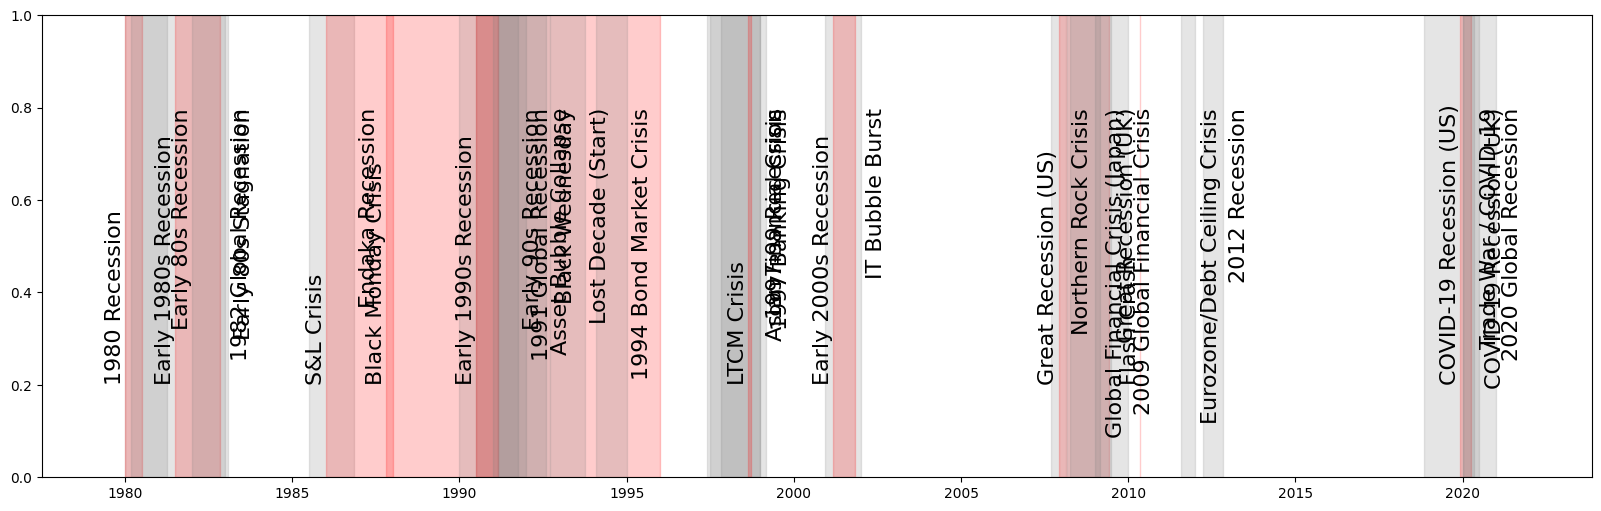

In [7]:
def plot_recession_timeline(df, ax=None, figsize=(20, 6), x_range=None):
    """
    Plots a timeline of US and Global recessions.
    Assumes df has columns: 'scope', 'start_date', 'end_date', 'event_name'
    """
    if not ax:
        fig, ax = plt.subplots(figsize=figsize)
    y_us = 0.2
    y_global = 0.8
    for idx, recession in df.iterrows():
        color = 'r' if recession["scope"] == "US" else 'gray'
        x = recession['start_date'] if recession["scope"] == "US" else recession['end_date']
        x = x-pd.Timedelta("1day") if recession["scope"] == "US" else x+pd.Timedelta("60days")
        y = y_us if recession["scope"] == "US" else y_global
        ha = 'right' if recession["scope"] == "US" else 'left'
        va = 'bottom' if recession["scope"] == "US" else 'top'
        ax.axvspan(recession["start_date"], recession["end_date"], color=color, alpha=0.2)
        ax.text(x, y, recession['event_name'], rotation=90, ha=ha, va=va, linespacing=5.2, fontsize=16)

    if x_range is not None:
        ax.set_xlim(x_range)

xrange = df_cumulants["Right"].iloc[0] - pd.Timedelta("1000d"), df_cumulants["Right"].iloc[-1] + pd.Timedelta("500d")
plot_recession_timeline(RECESSIONS, x_range=xrange)

In [12]:
def market_label(scope):
    if scope == "Global":
        return "Global"
    elif scope == "US":
        return "US"
    elif scope == "UK":
        return "LN"
    elif scope == "Japan":
        return "JT"
    else:
        return "Unknown"
    

RECESSIONS["Market"] = RECESSIONS["scope"].apply(market_label)

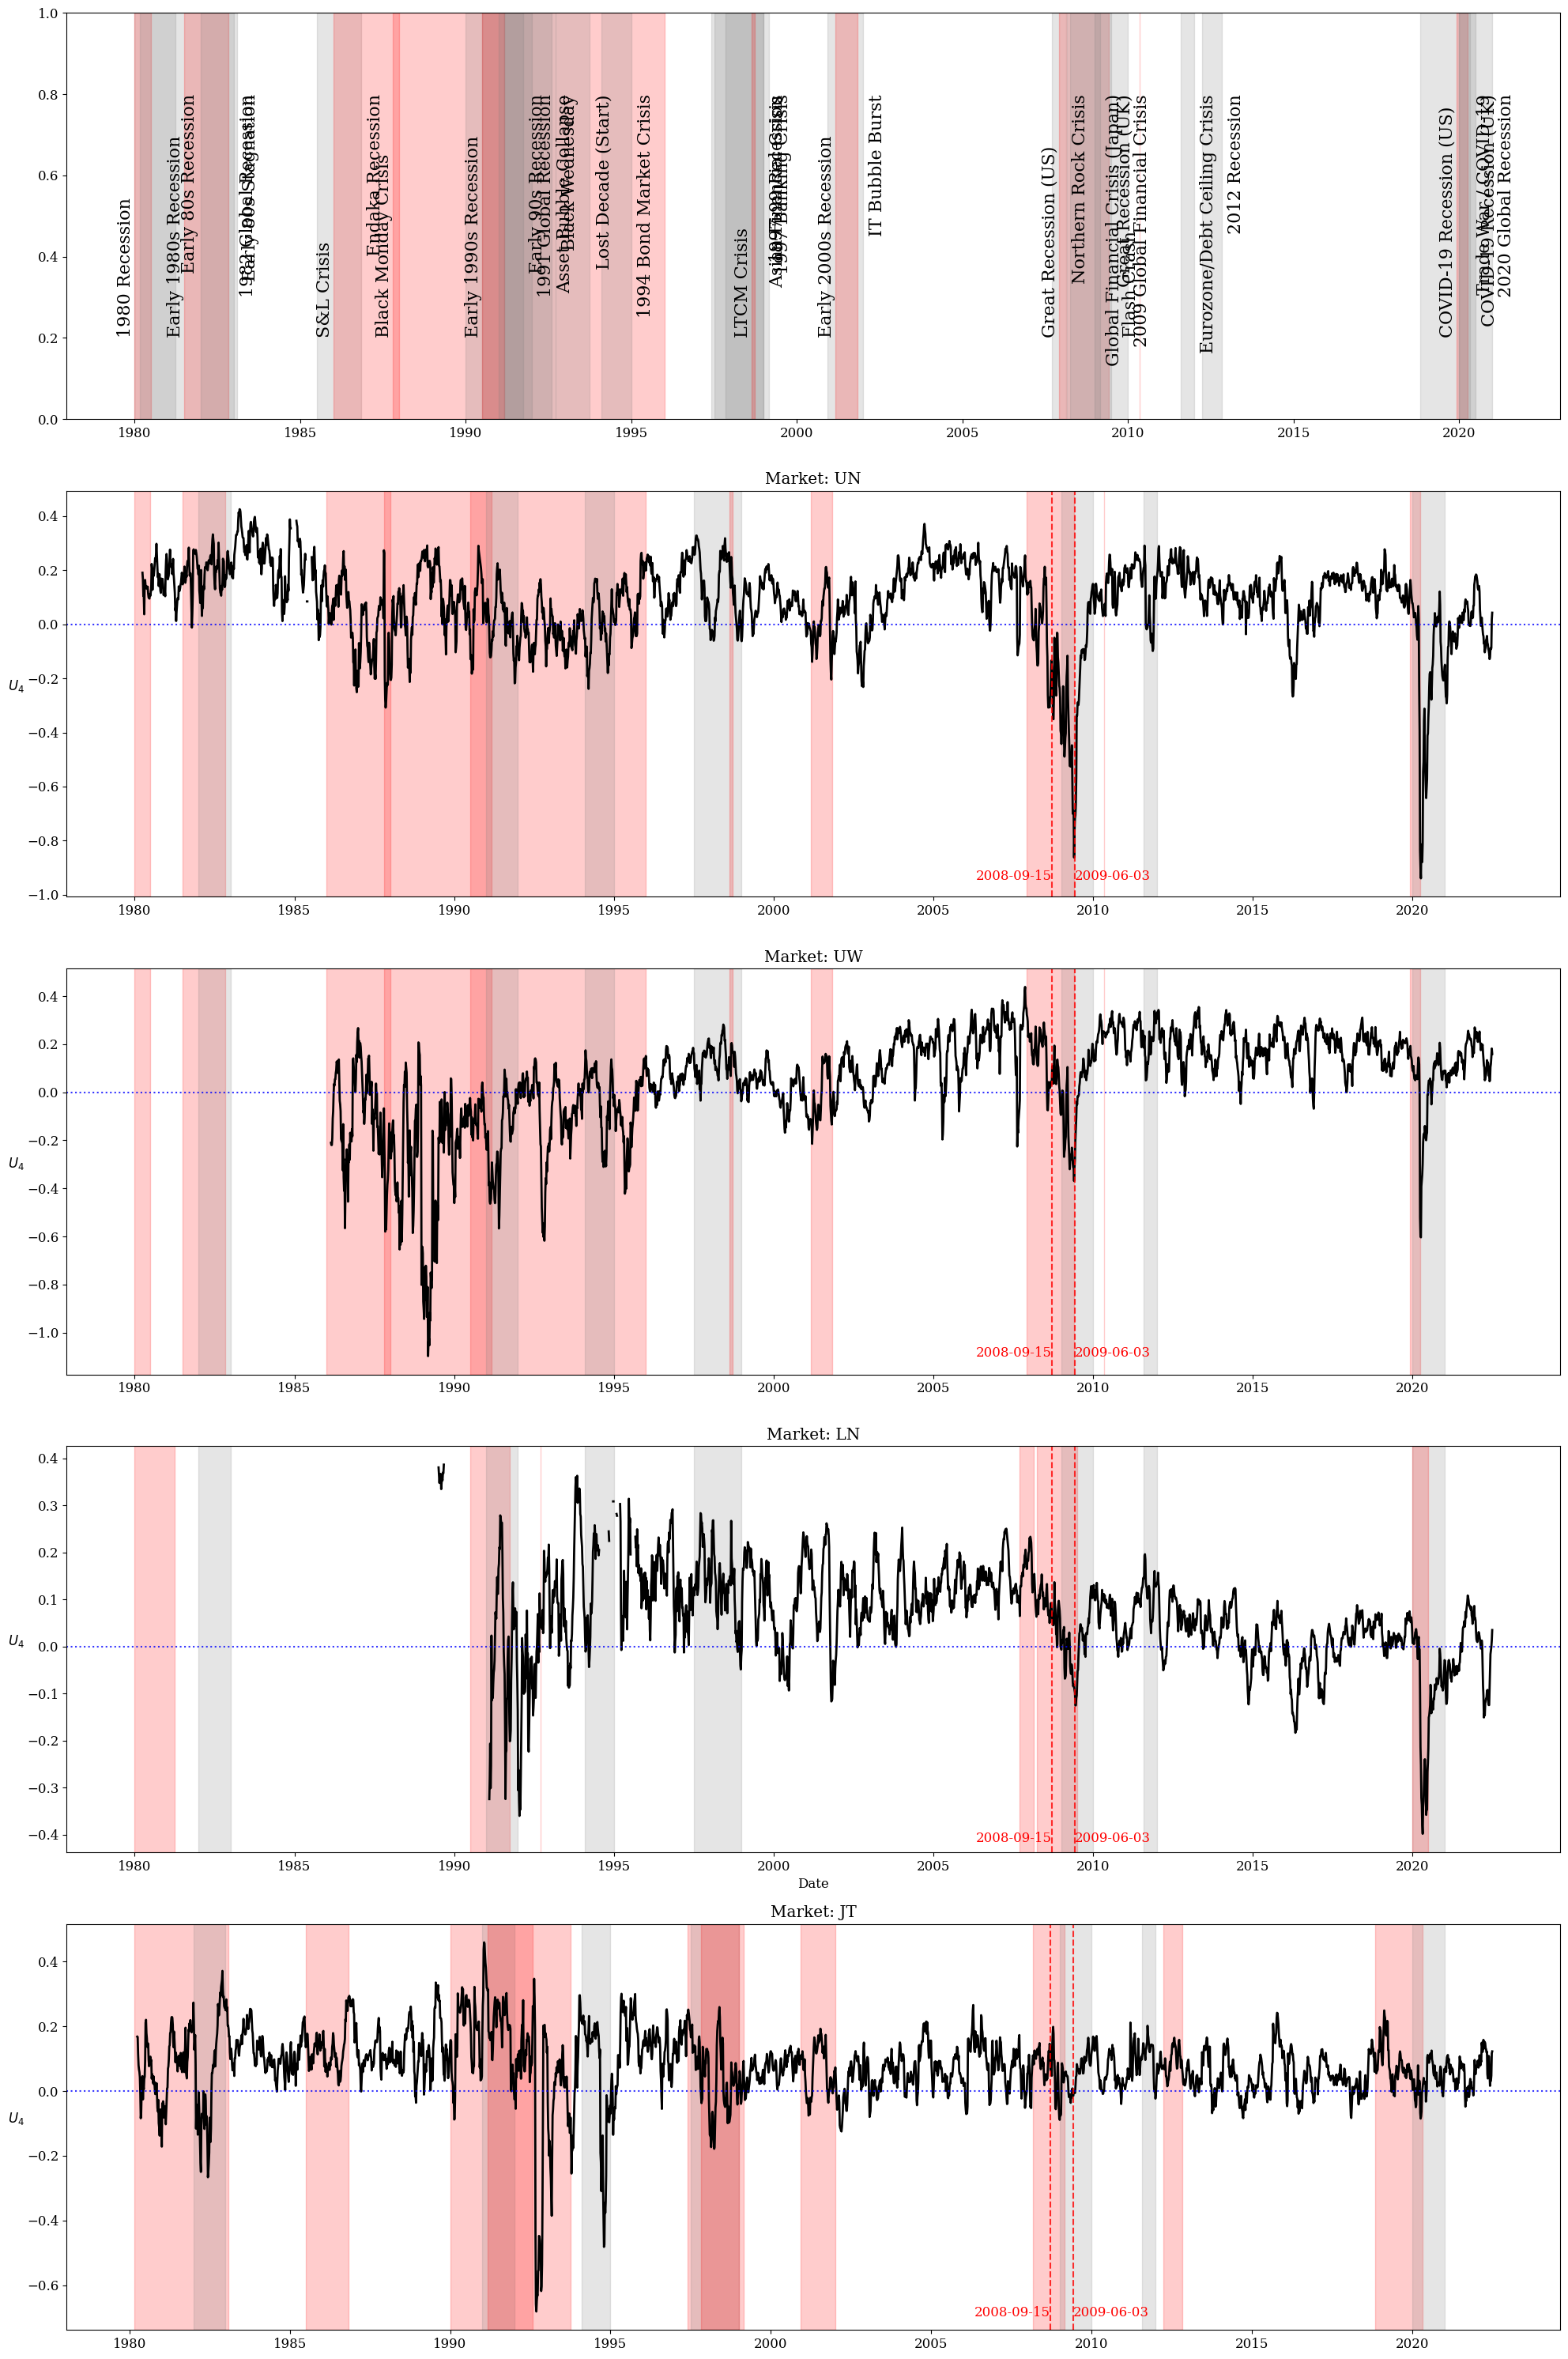

In [15]:
def plot_cumulants(cumulants, windows, markets, save=False, latex=False, **kwargs):
    plt.rcParams.update({'text.usetex': latex, 'font.family': 'serif', 'font.size': 12})
    events_plot = kwargs.get("events_legend", True)
    n_plots = len(markets) + 1 if events_plot else len(markets)

    fig, axs = plt.subplots(
        n_plots, 
        figsize=(kwargs.get("figsize", (18, 10))), 
        layout='tight', sharex=False)
    
    if n_plots == 1:
        axs = [axs]

    i = 0
    if events_plot:
        plot_recession_timeline(RECESSIONS, axs[0])
        i += 1

    for market in markets:
        ax = axs[i]
        ax.set_title(f'Market: {market}')
        ax.set_ylabel('$U_4$', rotation=0, labelpad=10)
        data_to_plot = cumulants[cumulants["Market"] == market]
        u4 = data_to_plot[data_to_plot["Window"].isin(windows)]
        ax.plot(u4["Right"], u4["U4"], color='k', lw=2)
        ax.axhline(0, ls=':', color='blue', alpha=0.8)

        ax.axvline(pd.to_datetime(CRISIS_STARTS), ls='--', color='red', alpha=0.8)
        ax.axvline(pd.to_datetime(CRISIS_ENDS), ls='--', color='red', alpha=0.8)
        ax.text(pd.to_datetime(CRISIS_STARTS), ax.get_ylim()[0]*0.9, f'{CRISIS_STARTS}', color='red', va='top', ha='right')
        ax.text(pd.to_datetime(CRISIS_ENDS), ax.get_ylim()[0]*0.9, f'{CRISIS_ENDS}', color='red', va='top', ha='left')

        if i == len(markets) - 1:
            ax.set_xlabel('Date')
    
        # Add recessions indicators
        market_scope = "US" if market in ["UN", "UW"] else market
        recessions = RECESSIONS[(RECESSIONS["Market"] == market_scope) | (RECESSIONS["Market"] == "Global")]
        for row, recession in recessions.iterrows():
            color = 'gray' if recession["scope"] == "Global" else 'r'
            ax.axvspan(recession["start_date"], recession["end_date"], color=color, alpha=0.2)

        i += 1

    if save:
        fig.savefig(f'../visualization/dynamics/binder_cumulants_{WINDOW_LEN}d.png', bbox_inches='tight')
        fig.savefig(f'../visualization/dynamics/binder_cumulants_{WINDOW_LEN}d.pdf', bbox_inches='tight')
    
    plt.show()

plot_cumulants(df_cumulants, all_windows, MARKETS, save=False, latex=False, figsize=(20, 30))

## Why is this happening
The Binder cumulant is a comparison between fourth (kurtosis) and second (variance) moments of the distribution of FHT.
We track the evolution of these moments separately to see in greater details what is happening.

In [ ]:
def second_moment(data):
    x = np.asarray(data, dtype=float).ravel()
    if x.size < 2:
        return np.nan
    return np.mean(x**2)

def fourth_moment(data):
    x = np.asarray(data, dtype=float).ravel()
    if x.size < 2:
        return np.nan
    return np.mean(x**4)

## Looking at the Distributions
If we look at the shape of the distributions in different time windows, we can see how it changes during the crisis.
Obviously, the more data we have in the windows, the more ``precise'' the distribution will be.

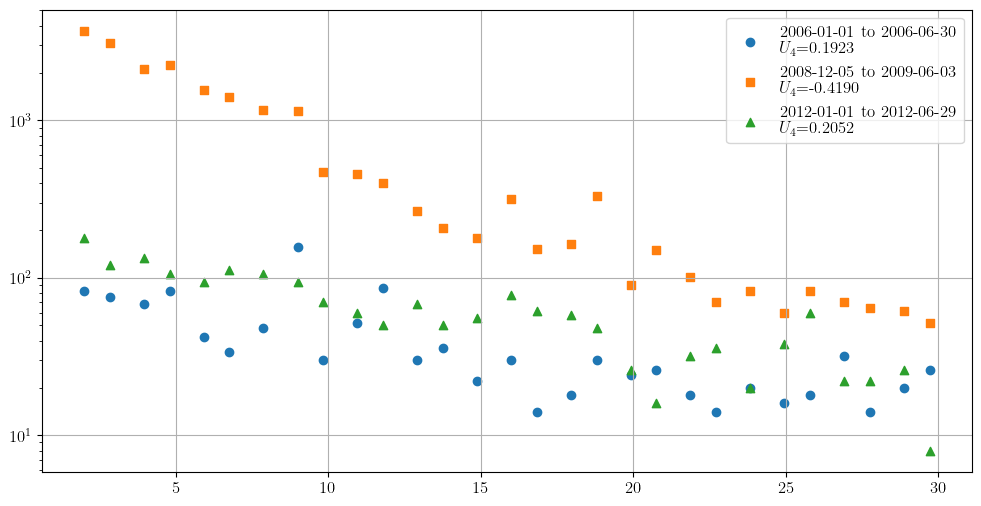

In [13]:
dates = [
    (pd.to_datetime("2006-01-01"), pd.to_datetime("2006-01-01") + 2*pd.Timedelta(days=WINDOW_LEN)),
    (pd.to_datetime(CRISIS_ENDS) - 2*pd.Timedelta(days=WINDOW_LEN), pd.to_datetime(CRISIS_ENDS)),
    (pd.to_datetime("2012-01-01"), pd.to_datetime("2012-01-01") + 2*pd.Timedelta(days=WINDOW_LEN)),
]
markers = ['o', 's', '^']
market = "UN"
fig, ax = plt.subplots(figsize=(12, 6))
pdfs = []
for window, marker in zip(dates, markers):
    data = query_binned_data(
                market, window[0], window[1], t1_string=THRESHOLDS[0], t2_string=THRESHOLDS[1], conn=conn, min_bins=-1
            )[0]["FHT"].values
    pdfs.append(data)
    binder = binder_cumulant(data, centered=False)
    hist, bin_edges = np.histogram(data, bins=100, density=False)
    mask = np.where(hist > 0)
    ax.scatter(bin_edges[:-1][mask], hist[mask], marker=marker, label=f"{window[0].date()} to {window[1].date()}\n$U_4$={binder:.4f}")

ax.set_yscale('log')
ax.grid()
ax.legend()

In [12]:
# TODO: check if there is a power law and if there are already references of FHT power laws in literature

### Characterizing the Distributions
Are the pdfs far from the crisis Gaussians? 
Is the crisis pdf a Levy?

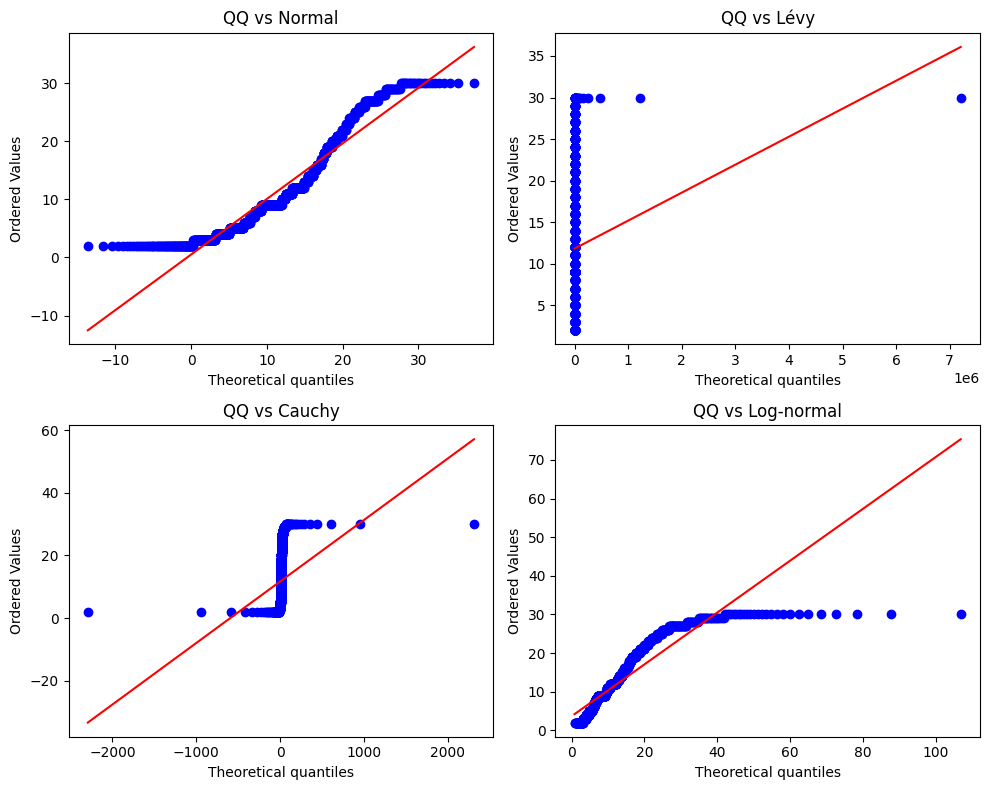

{'normal': {'params': {'mu': np.float64(11.855670103092784), 'sigma': np.float64(7.86285760430653)}, 'ks': KstestResult(statistic=np.float64(0.1469212059692382), pvalue=np.float64(2.149897416846132e-22), statistic_location=np.int64(9), statistic_sign=np.int8(1)), 'logL': np.float64(-4051.9871728414028), 'AIC': np.float64(8107.9743456828055), 'BIC': np.float64(8118.093580939389)}, 'levy': {'params': {'loc': np.float64(1.2969429919120494), 'scale': np.float64(4.010837052830929)}, 'ks': KstestResult(statistic=np.float64(0.29145593296869243), pvalue=np.float64(4.447218446163576e-88), statistic_location=np.int64(30), statistic_sign=np.int8(1)), 'logL': np.float64(-4302.740446337535), 'AIC': np.float64(8609.48089267507), 'BIC': np.float64(8619.600127931653)}, 'cauchy': {'params': {'loc': np.float64(9.268787188921806), 'scale': np.float64(4.306601900262963)}, 'ks': KstestResult(statistic=np.float64(0.170254666549676), pvalue=np.float64(5.736263793866125e-30), statistic_location=np.int64(2), s

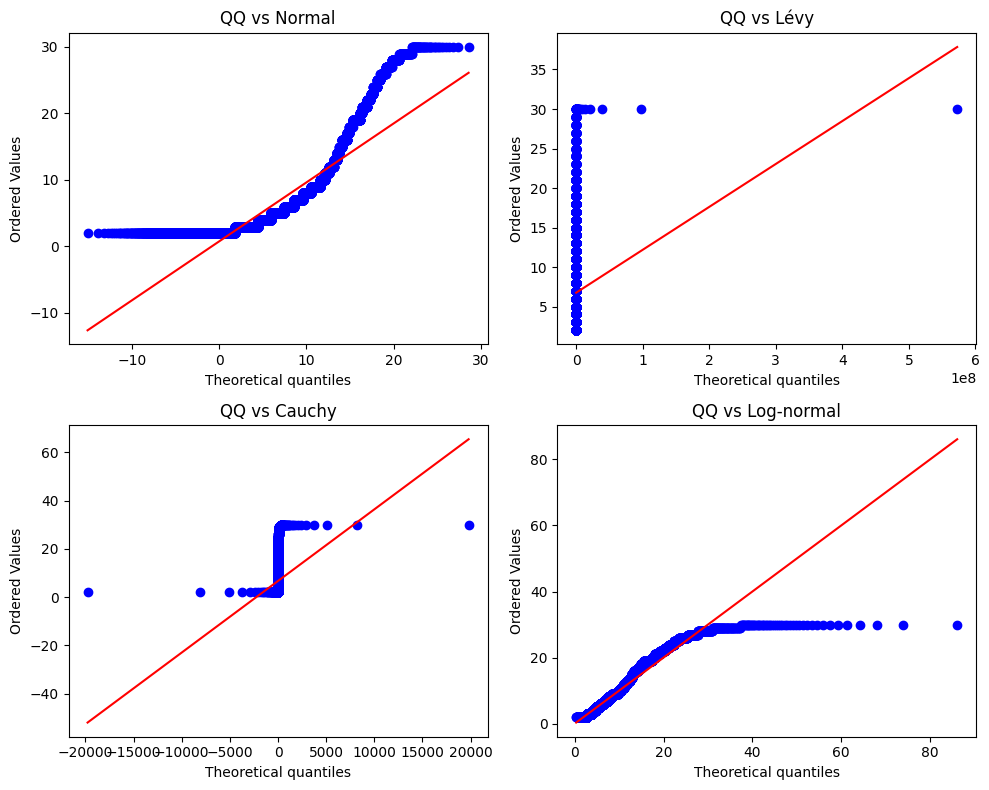

{'normal': {'params': {'mu': np.float64(6.759731940475017), 'sigma': np.float64(5.48256890415365)}, 'ks': KstestResult(statistic=np.float64(0.19265412694417927), pvalue=np.float64(0.0), statistic_location=np.int64(2), statistic_sign=np.int8(-1)), 'logL': np.float64(-63327.67666597477), 'AIC': np.float64(126659.35333194953), 'BIC': np.float64(126675.18949305921)}, 'levy': {'params': {'loc': np.float64(1.7336111265578342), 'scale': np.float64(1.0492264900541413)}, 'ks': KstestResult(statistic=np.float64(0.1790016820092762), pvalue=np.float64(0.0), statistic_location=np.int64(3), statistic_sign=np.int8(-1)), 'logL': np.float64(-57058.58450717124), 'AIC': np.float64(114121.16901434248), 'BIC': np.float64(114137.00517545216)}, 'cauchy': {'params': {'loc': np.float64(4.450023361835149), 'scale': np.float64(2.1232602780407595)}, 'ks': KstestResult(statistic=np.float64(0.2272952064462705), pvalue=np.float64(0.0), statistic_location=np.int64(2), statistic_sign=np.int8(-1)), 'logL': np.float64(-

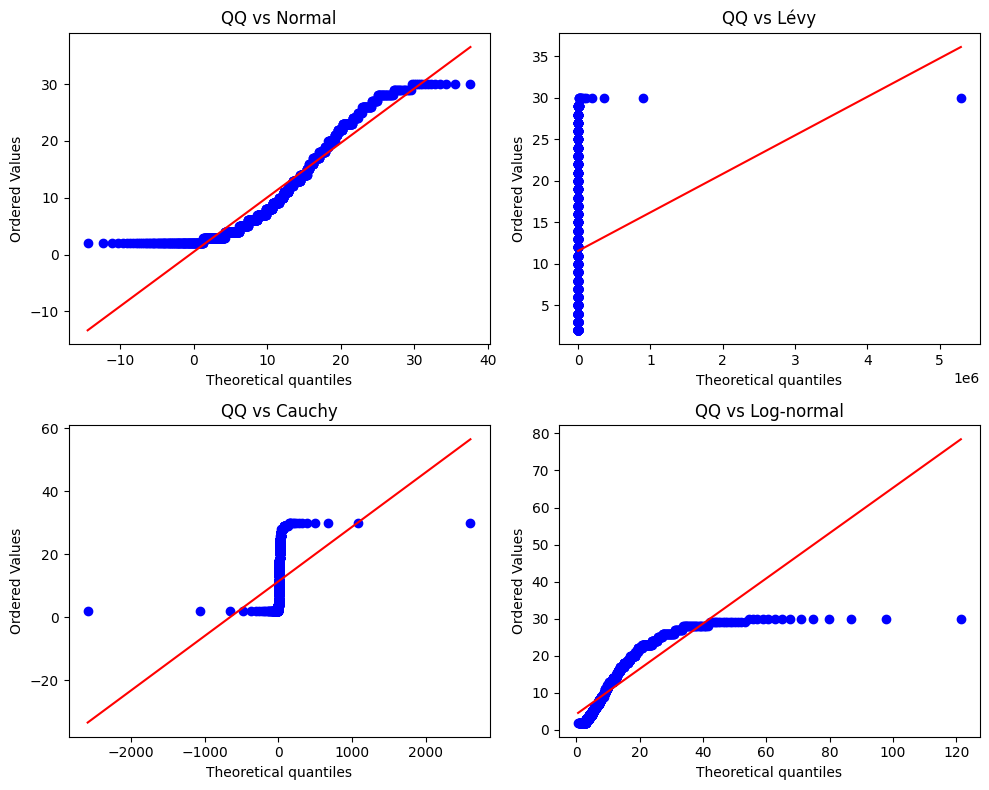

{'normal': {'params': {'mu': np.float64(11.601436265709156), 'sigma': np.float64(8.053626239353862)}, 'ks': KstestResult(statistic=np.float64(0.129045054067482), pvalue=np.float64(1.23976496688056e-16), statistic_location=np.int64(7), statistic_sign=np.int8(1)), 'logL': np.float64(-3904.637940322833), 'AIC': np.float64(7813.275880645666), 'BIC': np.float64(7823.30730548664)}, 'levy': {'params': {'loc': np.float64(1.350412360398034), 'scale': np.float64(3.21754136031708)}, 'ks': KstestResult(statistic=np.float64(0.2624669085032476), pvalue=np.float64(3.3110285611005607e-68), statistic_location=np.int64(30), statistic_sign=np.int8(1)), 'logL': np.float64(-4054.3528560263594), 'AIC': np.float64(8112.705712052719), 'BIC': np.float64(8122.737136893693)}, 'cauchy': {'params': {'loc': np.float64(8.662088208796106), 'scale': np.float64(5.080684313072557)}, 'ks': KstestResult(statistic=np.float64(0.20738944225028902), pvalue=np.float64(1.6761580263829383e-42), statistic_location=np.int64(2), st

In [33]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

def compare_normal_levy_cauchy(data, make_plots=True):
    """
    Compare Normal, Lévy, Cauchy and Log-normal on the ORIGINAL scale.
    Assumes data are 1D and > 0 (log-normal + levy need positive support).
    """
    x = np.asarray(data)

    # Basic sanity: lognormal and levy need positive x
    if np.any(x <= 0):
        raise ValueError("compare_normal_levy_cauchy: all data must be > 0 to include log-normal and Lévy.")

    # ---- Fit distributions ----
    # Normal
    mu_norm, sigma_norm = stats.norm.fit(x)

    # Lévy (one-sided, scipy.stats.levy)
    loc_levy, scale_levy = stats.levy.fit(x)

    # Cauchy
    loc_cauchy, scale_cauchy = stats.cauchy.fit(x)

    # Log-normal
    # scipy lognorm: shape (s), loc, scale
    # If Y ~ N(mu, sigma), X = exp(Y) -> s = sigma, loc=0, scale=exp(mu)
    s_logn, loc_logn, scale_logn = stats.lognorm.fit(x, floc=0)  # often fix loc=0 for log-normal

    # ---- KS tests ----
    ks_norm = stats.kstest(x, 'norm',   args=(mu_norm, sigma_norm))
    ks_levy = stats.kstest(x, 'levy',   args=(loc_levy, scale_levy))
    ks_cauchy = stats.kstest(x, 'cauchy', args=(loc_cauchy, scale_cauchy))
    ks_logn = stats.kstest(x, 'lognorm', args=(s_logn, loc_logn, scale_logn))

    # ---- Log-likelihoods ----
    ll_norm   = np.sum(stats.norm.logpdf(x,   mu_norm, sigma_norm))
    ll_levy   = np.sum(stats.levy.logpdf(x,   loc_levy, scale_levy))
    ll_cauchy = np.sum(stats.cauchy.logpdf(x, loc_cauchy, scale_cauchy))
    ll_logn   = np.sum(stats.lognorm.logpdf(x, s_logn, loc_logn, scale_logn))

    n = len(x)
    k_norm   = 2  # mu, sigma
    k_levy   = 2  # loc, scale
    k_cauchy = 2  # loc, scale
    k_logn   = 3  # shape, loc, scale (we fixed loc=0, but still 2–3 params depending how you want to count)

    def aic(ll, k): return 2 * k - 2 * ll
    def bic(ll, k): return k * np.log(n) - 2 * ll

    results = {
        "normal": {
            "params": {"mu": mu_norm, "sigma": sigma_norm},
            "ks": ks_norm,
            "logL": ll_norm,
            "AIC": aic(ll_norm, k_norm),
            "BIC": bic(ll_norm, k_norm),
        },
        "levy": {
            "params": {"loc": loc_levy, "scale": scale_levy},
            "ks": ks_levy,
            "logL": ll_levy,
            "AIC": aic(ll_levy, k_levy),
            "BIC": bic(ll_levy, k_levy),
        },
        "cauchy": {
            "params": {"loc": loc_cauchy, "scale": scale_cauchy},
            "ks": ks_cauchy,
            "logL": ll_cauchy,
            "AIC": aic(ll_cauchy, k_cauchy),
            "BIC": bic(ll_cauchy, k_cauchy),
        },
        "lognormal": {
            "meaning": "X > 0, log(X) ~ Normal",
            "params_raw": {"shape": s_logn, "loc": loc_logn, "scale": scale_logn},
            "ks": ks_logn,
            "logL": ll_logn,
            "AIC": aic(ll_logn, k_logn),
            "BIC": bic(ll_logn, k_logn),
        },
    }

    # ---- Optional QQ-plots ----
    if make_plots:
        fig, axs = plt.subplots(2, 2, figsize=(10, 8))

        stats.probplot(x, dist=stats.norm,
                       sparams=(mu_norm, sigma_norm), plot=axs[0, 0])
        axs[0, 0].set_title("QQ vs Normal")

        stats.probplot(x, dist=stats.levy,
                       sparams=(loc_levy, scale_levy), plot=axs[0, 1])
        axs[0, 1].set_title("QQ vs Lévy")

        stats.probplot(x, dist=stats.cauchy,
                       sparams=(loc_cauchy, scale_cauchy), plot=axs[1, 0])
        axs[1, 0].set_title("QQ vs Cauchy")

        stats.probplot(x, dist=stats.lognorm,
                       sparams=(s_logn, loc_logn, scale_logn), plot=axs[1, 1])
        axs[1, 1].set_title("QQ vs Log-normal")

        plt.tight_layout()
        plt.show()

    return results


results = []
for data in pdfs:
    res = compare_normal_levy_cauchy(data, make_plots=True)
    results.append(res)
    print(res)

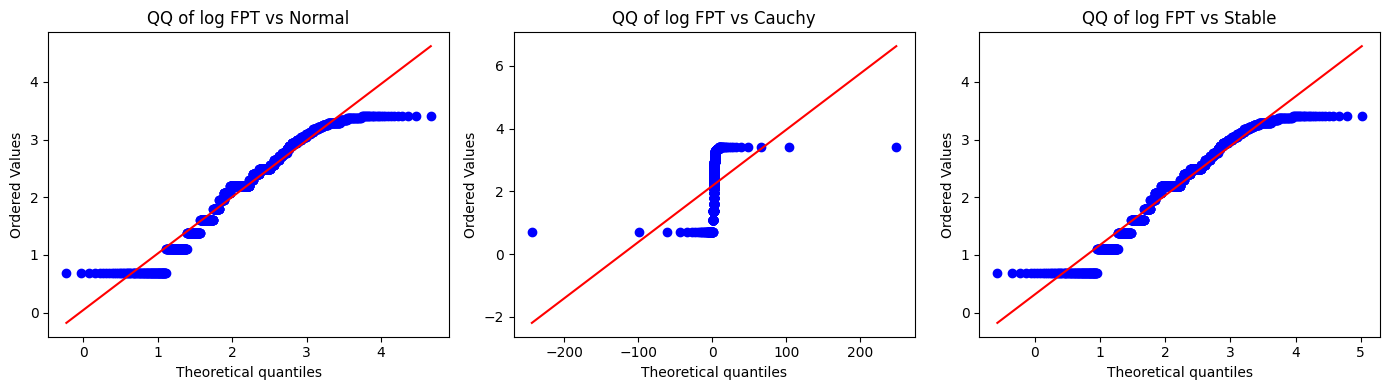

{'normal_on_log': {'meaning_on_X': 'log-normal FPTs', 'params_Y': {'mu': np.float64(2.220763055266127), 'sigma': np.float64(0.7560264898860649)}, 'ks': KstestResult(statistic=np.float64(0.11644713257017886), pvalue=np.float64(3.300614556322225e-14), statistic_location=np.float64(2.1972245773362196), statistic_sign=np.int8(-1)), 'logL': np.float64(-1326.0982550885155), 'AIC': np.float64(2656.196510177031), 'BIC': np.float64(2666.3157454336138)}, 'cauchy_on_log': {'meaning_on_X': 'log-Cauchy FPTs', 'params_Y': {'loc': np.float64(2.3314140736743543), 'scale': np.float64(0.4608014848713745)}, 'ks': KstestResult(statistic=np.float64(0.12946452455468038), pvalue=np.float64(1.8066054272391563e-17), statistic_location=np.float64(3.4011973816621555), statistic_sign=np.int8(1)), 'logL': np.float64(-1564.6505648724033), 'AIC': np.float64(3133.3011297448065), 'BIC': np.float64(3143.420365001389)}, 'stable_on_log': {'meaning_on_X': 'log-stable FPTs', 'params_Y': {'alpha': np.float64(2.0), 'beta': n

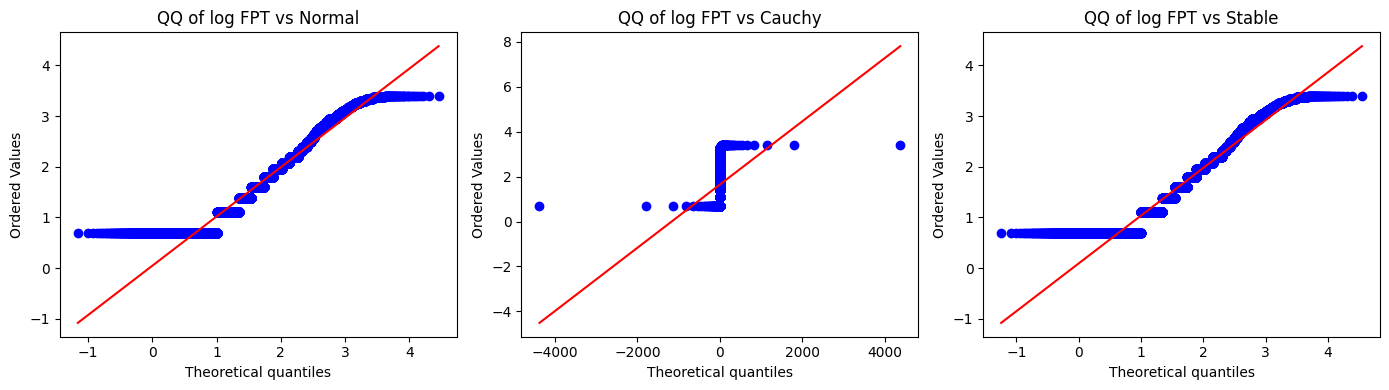

{'normal_on_log': {'meaning_on_X': 'log-normal FPTs', 'params_Y': {'mu': np.float64(1.6488962504923186), 'sigma': np.float64(0.7048849447151355)}, 'ks': KstestResult(statistic=np.float64(0.11925207110635416), pvalue=np.float64(6.226332883308239e-252), statistic_location=np.float64(1.0986122886681098), statistic_sign=np.int8(1)), 'logL': np.float64(-21698.706940966393), 'AIC': np.float64(43401.413881932785), 'BIC': np.float64(43417.25004304246)}, 'cauchy_on_log': {'meaning_on_X': 'log-Cauchy FPTs', 'params_Y': {'loc': np.float64(1.5899359742205799), 'scale': np.float64(0.469745480235199)}, 'ks': KstestResult(statistic=np.float64(0.1535884649378826), pvalue=np.float64(0.0), statistic_location=np.float64(0.6931471805599453), statistic_sign=np.int8(-1)), 'logL': np.float64(-26391.93068337799), 'AIC': np.float64(52787.86136675598), 'BIC': np.float64(52803.697527865654)}, 'stable_on_log': {'meaning_on_X': 'log-stable FPTs', 'params_Y': {'alpha': np.float64(2.0), 'beta': np.float64(1.0), 'loc

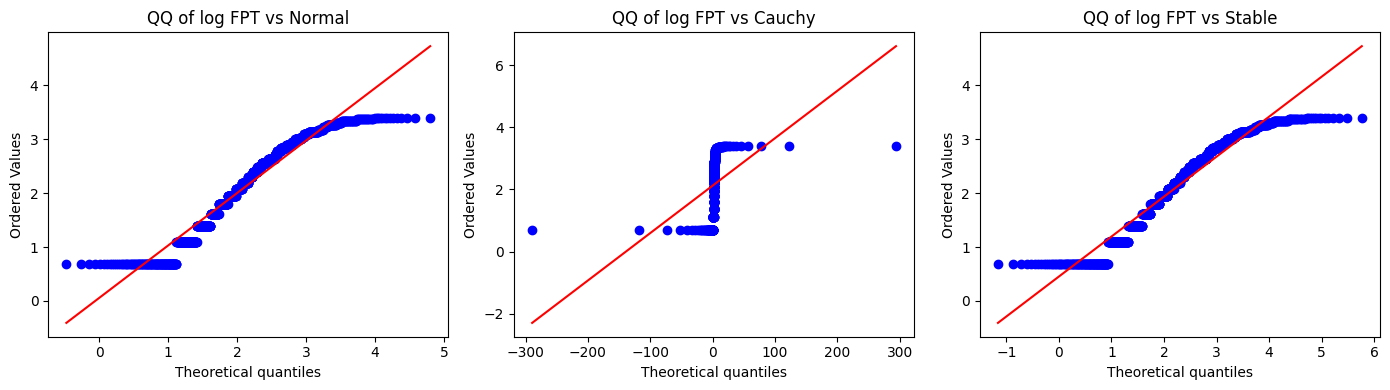

{'normal_on_log': {'meaning_on_X': 'log-normal FPTs', 'params_Y': {'mu': np.float64(2.1595929413787274), 'sigma': np.float64(0.8175617513239184)}, 'ks': KstestResult(statistic=np.float64(0.09752664565346403), pvalue=np.float64(1.1262936682296096e-09), statistic_location=np.float64(2.5649493574615367), statistic_sign=np.int8(-1)), 'logL': np.float64(-1356.3057956947414), 'AIC': np.float64(2716.611591389483), 'BIC': np.float64(2726.6430162304573)}, 'cauchy_on_log': {'meaning_on_X': 'log-Cauchy FPTs', 'params_Y': {'loc': np.float64(2.3208528702731956), 'scale': np.float64(0.5702849033034716)}, 'ks': KstestResult(statistic=np.float64(0.154602066252427), pvalue=np.float64(1.0200053816265382e-23), statistic_location=np.float64(3.4011973816621555), statistic_sign=np.int8(1)), 'logL': np.float64(-1647.9695818078537), 'AIC': np.float64(3299.9391636157075), 'BIC': np.float64(3309.970588456682)}, 'stable_on_log': {'meaning_on_X': 'log-stable FPTs', 'params_Y': {'alpha': np.float64(2.0), 'beta': n

In [13]:
# Try with logarithm of FHT


def compare_on_log(pdf, make_plots=True):
    y = np.log(pdf)  # transform
    y = np.asarray(y)

    # Fit models on Y = log X
    mu_norm, sigma_norm = stats.norm.fit(y)
    loc_cauchy, scale_cauchy = stats.cauchy.fit(y)
    alpha_st, beta_st, loc_st, scale_st = stats.levy_stable.fit(y)

    # KS tests
    ks_norm = stats.kstest(y, 'norm',   args=(mu_norm, sigma_norm))
    ks_cauchy = stats.kstest(y, 'cauchy', args=(loc_cauchy, scale_cauchy))
    ks_stable = stats.kstest(y, 'levy_stable',
                             args=(alpha_st, beta_st, loc_st, scale_st))

    # Log-likelihoods
    ll_norm   = np.sum(stats.norm.logpdf(y,   mu_norm, sigma_norm))
    ll_cauchy = np.sum(stats.cauchy.logpdf(y, loc_cauchy, scale_cauchy))
    ll_stable = np.sum(stats.levy_stable.logpdf(y, alpha_st, beta_st, loc_st, scale_st))

    n = len(y)
    k_norm   = 2          # mu, sigma
    k_cauchy = 2          # loc, scale
    k_stable = 4          # alpha, beta, loc, scale

    def aic(ll, k): return 2 * k - 2 * ll
    def bic(ll, k): return k * np.log(n) - 2 * ll

    results = {
        "normal_on_log": {
            "meaning_on_X": "log-normal FPTs",
            "params_Y": {"mu": mu_norm, "sigma": sigma_norm},
            "ks": ks_norm,
            "logL": ll_norm,
            "AIC": aic(ll_norm, k_norm),
            "BIC": bic(ll_norm, k_norm),
        },
        "cauchy_on_log": {
            "meaning_on_X": "log-Cauchy FPTs",
            "params_Y": {"loc": loc_cauchy, "scale": scale_cauchy},
            "ks": ks_cauchy,
            "logL": ll_cauchy,
            "AIC": aic(ll_cauchy, k_cauchy),
            "BIC": bic(ll_cauchy, k_cauchy),
        },
        "stable_on_log": {
            "meaning_on_X": "log-stable FPTs",
            "params_Y": {
                "alpha": alpha_st, "beta": beta_st,
                "loc": loc_st, "scale": scale_st,
            },
            "ks": ks_stable,
            "logL": ll_stable,
            "AIC": aic(ll_stable, k_stable),
            "BIC": bic(ll_stable, k_stable),
        },
    }

    if make_plots:
        fig, axs = plt.subplots(1, 3, figsize=(14, 4))

        stats.probplot(y, dist=stats.norm,
                       sparams=(mu_norm, sigma_norm), plot=axs[0])
        axs[0].set_title("QQ of log FPT vs Normal")

        stats.probplot(y, dist=stats.cauchy,
                       sparams=(loc_cauchy, scale_cauchy), plot=axs[1])
        axs[1].set_title("QQ of log FPT vs Cauchy")

        stats.probplot(y, dist=stats.levy_stable,
                       sparams=(alpha_st, beta_st, loc_st, scale_st),
                       plot=axs[2])
        axs[2].set_title("QQ of log FPT vs Stable")

        plt.tight_layout()
        plt.show()

    return results

for data in pdfs:
    res = compare_on_log(data)
    print(res)

In [112]:
pdfs

NameError: name 'pdfs' is not defined

**Result:** the PDF is most probably log-normal for all the three dates

In [ ]:


def fit_distributions(data):
    # Fit distributions
    # Gaussian (truncated at 0)
    mu, sigma = data.mean(), data.std()

    # Lévy stable distribution
    levy_params = stats.levy_stable.fit(data)

    # Generate PDFs for plotting
    x = np.linspace(data.min(), data.max(), 1000)
    gaussian_pdf = stats.norm.pdf(x, mu, sigma)
    levy_pdf = stats.levy_stable.pdf(x, *levy_params)

    # Plot comparison
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))

    # Histogram with fitted PDFs
    axes[0].hist(data, bins=50, density=True, alpha=0.6, label='Data')
    axes[0].plot(x, gaussian_pdf, 'r-', lw=2, label='Gaussian')
    axes[0].plot(x, levy_pdf, 'b-', lw=2, label='Lévy')
    axes[0].set_xlabel('Time')
    axes[0].set_ylabel('Density')
    axes[0].legend()
    axes[0].set_title('PDF Comparison')

    # Log-scale (reveals tails)
    axes[1].hist(data, bins=50, density=True, alpha=0.6)
    axes[1].plot(x, gaussian_pdf, 'r-', lw=2, label='Gaussian')
    axes[1].plot(x, levy_pdf, 'b-', lw=2, label='Lévy')
    axes[1].set_yscale('log')
    axes[1].set_xlabel('Time')
    axes[1].set_ylabel('Log Density')
    axes[1].legend()
    axes[1].set_title('Log-scale (Fat Tails)')

    # Q-Q plots
    axes[2].scatter(stats.norm.ppf(np.linspace(0.01, 0.99, len(data))), 
                    np.sort(data), alpha=0.5, label='vs Gaussian', s=20)
    axes[2].plot(np.sort(data), np.sort(data), 'k--', label='Perfect fit')
    axes[2].set_xlabel('Theoretical Quantiles')
    axes[2].set_ylabel('Data Quantiles')
    axes[2].legend()
    axes[2].set_title('Q-Q Plot')

    plt.tight_layout()
    plt.show()

    # Goodness of fit tests
    print(f"Gaussian: μ={mu:.3f}, σ={sigma:.3f}")
    print(f"Lévy params: α={levy_params[0]:.3f}, β={levy_params[1]:.3f}")
    print(f"\nKS test (Gaussian): {stats.kstest(data, 'norm', args=(mu, sigma))}")
    print(f"KS test (Lévy): {stats.kstest(data, 'levy_stable', args=levy_params)}")